Interactively figure out MGRS tiles and track numbers

In [1]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [2]:
yaml_file = 'events/chile_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chile_fire_2024',
 'bounds': [-71.53071089, -33.20143816, -71.2964628, -32.98270579],
 'event_date': '2024-02-04',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [18, 156],
 'mgrs_tiles': ['19HBD'],
 'source_id': 'EMSR715',
 'dist_hls_confirmed_change_min_days': 30,
 'links': ['https://earthobservatory.nasa.gov/images/152411/fires-rage-in-central-chile',
  'https://en.wikipedia.org/wiki/2024_Chile_wildfires']}

# Read Geojson

<Axes: >

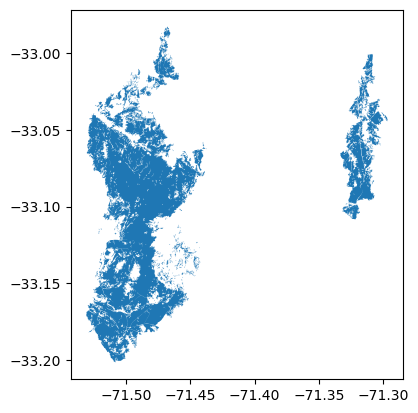

In [5]:
df_event = gpd.read_file(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
df_event.plot()

In [6]:
df_event.total_bounds

array([-71.53071089, -33.20143816, -71.2964628 , -32.98270579])

# Create Spatial AOI

In [4]:
aoi = box(*event_dict['bounds'])
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

# Find MGRS tiles and Explore

In [5]:
df_mgrs = gpd.read_file('https://raw.githubusercontent.com/NASA-IMPACT/hls-land_tiles/master/s2_grid.json')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
df_mgrs_overlapping.rename(columns={'identifier': 'tile_id'}, inplace=True)
# Remove extra column
df_mgrs_overlapping.drop(columns='type', inplace=True)
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda multi_geo: unary_union(multi_geo.geoms))
# Makes 3d or Z dimension go away
df_mgrs_overlapping['geometry'] = df_mgrs_overlapping.geometry.map(lambda geo: force_2d(geo))
df_mgrs_overlapping.head()

,tile_id,geometry
0,19HBD,"POLYGON ((-72.19295 -32.49681, -71.02522 -32.5..."


In [6]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [8]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['19HBD']

In [11]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

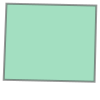

In [12]:
search_geo

# Explore Availability of RTC Data

In [13]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [14]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


375

In [15]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

["'type': 'REVERSE': 'report': Reversed polygon winding order"]


254

In [16]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
m

In [17]:
df_rtc_resp_pre_e.pathNumber.unique()

array([156,  91,  83,  18])

In [18]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber == 130].reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

In [19]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((-71.19107 -33.72822, -72.22363 -33.4...",-33.686367,-71.734989,2024-04-02T10:04:56Z,OPERA_L2_RTC-S1_T156-334210-IW2_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:52Z,...,None,IW2,OPERA_L2_RTC-S1_T156-334210-IW2_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((-72.07911 -33.40033, -72.97410 -33.1...",-33.371134,-72.554957,2024-04-02T10:04:54Z,OPERA_L2_RTC-S1_T156-334209-IW3_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:51Z,...,None,IW3,OPERA_L2_RTC-S1_T156-334209-IW3_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((-71.13709 -33.56423, -72.16763 -33.3...",-33.522527,-71.679852,2024-04-02T10:04:53Z,OPERA_L2_RTC-S1_T156-334209-IW2_20240402T10045...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:50Z,...,None,IW2,OPERA_L2_RTC-S1_T156-334209-IW2_20240402T10045...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((-70.27332 -33.70288, -71.25331 -33.4...",-33.671472,-70.790071,2024-04-02T10:04:52Z,OPERA_L2_RTC-S1_T156-334209-IW1_20240402T10044...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:49Z,...,None,IW1,OPERA_L2_RTC-S1_T156-334209-IW1_20240402T10044...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((-72.02340 -33.23666, -72.91677 -33.0...",-33.207702,-72.498333,2024-04-02T10:04:51Z,OPERA_L2_RTC-S1_T156-334208-IW3_20240402T10044...,DESCENDING,156,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-02T10:04:48Z,...,None,IW3,OPERA_L2_RTC-S1_T156-334208-IW3_20240402T10044...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
